In [139]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import csv
import math
import matplotlib.pyplot as plt
import seaborn as sns

Примечание:  
- Будем строить когортный анализ  
- Я решила рассмотреть retention по месяцам, потому что если строить по годам, то за 4 года мы сможем построить всего 12/2 = 6 информативных квадратиков карты retention'a, а это, наверное, маловато для выводов  
- Также я решила рассмотреть весь временной период, а не только последние 2 года, про которые спрашивает руководитель продукта. Прибыль магазину делают как новые, так и постоянные покупатели, и если отток пользователей связан с проблемами с доставкой, как предполагает руководитель, то это скорее одинаково отразится на retention'e всех когорт

In [140]:
orders_df = pd.read_csv('orders.csv')
orders_df['order_date'] = pd.to_datetime(orders_df['order_date'], format='%Y-%m-%d %H:%M:%S')
orders_df

,id,order_date,ship_mode,customer_id,sales
0,100006,2014-09-07,Standard,DK-13375,377.970
1,100090,2014-07-08,Standard,EB-13705,699.192
2,100293,2014-03-14,Standard,NF-18475,91.056
3,100328,2014-01-28,Standard,JC-15340,3.928
4,100363,2014-04-08,Standard,JM-15655,21.376
...,...,...,...,...,...
5004,168802,2017-11-03,Standard,JO-15145,18.368
5005,169320,2017-07-23,Second,LH-16900,171.430
5006,169488,2017-09-07,First,AA-10375,56.860
5007,169502,2017-08-28,Standard,MG-17650,113.410


In [141]:
customers_df = pd.read_csv('customers.csv')
customers_df

,id,name,segment,state,city
0,CG-12520,Claire Gute,Consumer,Kentucky,Henderson
1,DV-13045,Darrin Van Huff,Corporate,California,Los Angeles
2,SO-20335,Sean O'Donnell,Consumer,Florida,Fort Lauderdale
3,BH-11710,Brosina Hoffman,Consumer,California,Los Angeles
4,AA-10480,Andrew Allen,Consumer,North Carolina,Concord
...,...,...,...,...,...
788,CJ-11875,Carl Jackson,Corporate,Pennsylvania,Philadelphia
789,RS-19870,Roy Skaria,Home Office,Iowa,Burlington
790,SC-20845,Sung Chung,Consumer,Illinois,Arlington Heights
791,RE-19405,Ricardo Emerson,Consumer,Ohio,Kent


In [142]:
#  Найдем дату первой покупки для каждого кастомера
first_orders_df = orders_df.groupby('customer_id')['order_date'].agg(first_order='min')

first_orders_df.head()

,first_order
customer_id,
AA-10315,2014-03-31
AA-10375,2014-04-21
AA-10480,2014-05-04
AA-10645,2014-06-22
AB-10015,2014-02-18


In [143]:
#  Примержим дату первой покупки к каждому кастомеру
orders_df_merged = orders_df.merge(first_orders_df, how='left', left_on='customer_id', right_index=True)
orders_df_merged['order_date'] = pd.to_datetime(orders_df_merged['order_date'], format='%Y-%m-%d %H:%M:%S')
orders_df_merged['first_order'] = pd.to_datetime(orders_df_merged['first_order'], format='%Y-%m-%d %H:%M:%S')

#  Посчитаем дельту между датой первой покупки и текущей в месяцах
orders_df_merged['delta'] = ((orders_df_merged['order_date'] - orders_df_merged['first_order'])//np.timedelta64(1, 'M'))

#  Посчитаем для каждого пользователя месяц начала его пользования сайтом
orders_df_merged['start_month'] = ((orders_df_merged['first_order'] - orders_df_merged['first_order'].min())//np.timedelta64(1, 'M'))

orders_df_merged

,id,order_date,ship_mode,customer_id,sales,first_order,delta,start_month
0,100006,2014-09-07,Standard,DK-13375,377.970,2014-09-07,0,8
1,100090,2014-07-08,Standard,EB-13705,699.192,2014-07-08,0,6
2,100293,2014-03-14,Standard,NF-18475,91.056,2014-03-14,0,2
3,100328,2014-01-28,Standard,JC-15340,3.928,2014-01-28,0,0
4,100363,2014-04-08,Standard,JM-15655,21.376,2014-04-08,0,3
...,...,...,...,...,...,...,...,...
5004,168802,2017-11-03,Standard,JO-15145,18.368,2014-01-06,45,0
5005,169320,2017-07-23,Second,LH-16900,171.430,2014-08-19,35,7
5006,169488,2017-09-07,First,AA-10375,56.860,2014-04-21,40,3
5007,169502,2017-08-28,Standard,MG-17650,113.410,2014-08-09,36,7


In [144]:
#  Соберем в pivot
cohorts = orders_df_merged.pivot_table(index = ['start_month','delta'],
                        aggfunc = {'customer_id':'nunique'}).reset_index()
cohorts

,start_month,delta,customer_id
0,0,0,35
1,0,1,1
2,0,2,1
3,0,3,2
4,0,4,1
...,...,...,...
909,41,5,2
910,42,0,1
911,44,0,1
912,45,0,2


In [145]:
#  Найдем количество пользователей в каждой когорте
#  Мы можем вывести только строки, где время жизни когорты равно 0 (когорта формируется только в этот период), и извлечь только дату регистрации и количество пользователей
initial_users_count = cohorts[cohorts['delta'] == 0]
initial_users_count = initial_users_count[['start_month','customer_id']]
initial_users_count = initial_users_count.rename(columns={'customer_id':'cohort_users'})
initial_users_count

,start_month,cohort_users
0,0,35
48,1,34
94,2,59
140,3,56
185,4,56
229,5,43
272,6,47
313,7,47
353,8,70
393,9,46


In [146]:
#  Объединим с фреймом данных когорт, чтобы получить количество первоначальных клиентов в каждой когорте.
#  Затем найдем процент пользователей, которые оставались в каждый период времени, от первоначального числа клиентов в когорте
cohorts = cohorts.merge(initial_users_count,on='start_month')
cohorts['retention'] = cohorts['customer_id']/cohorts['cohort_users']
retention_pivot = cohorts.pivot_table(index='start_month',
                                      columns='delta',
                                      values='retention',
                                      aggfunc='sum')
retention_pivot

delta,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
start_month,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.028571,0.028571,0.057143,0.028571,0.028571,0.057143,0.171429,0.114286,0.142857,...,0.142857,0.114286,0.171429,0.057143,0.028571,0.228571,0.200000,0.257143,0.228571,0.028571
1,1.0,0.088235,0.058824,0.088235,0.147059,0.088235,0.058824,0.117647,0.176471,0.029412,...,0.117647,0.147059,0.147059,0.117647,0.352941,0.117647,0.294118,0.264706,0.029412,NaN
2,1.0,0.050847,0.101695,0.101695,0.033898,0.050847,0.118644,0.135593,0.084746,0.067797,...,0.186441,0.203390,0.101695,0.237288,0.152542,0.203390,0.203390,0.118644,NaN,NaN
3,1.0,0.071429,0.071429,0.053571,0.125000,0.089286,0.125000,0.125000,0.142857,0.053571,...,0.125000,0.142857,0.267857,0.142857,0.214286,0.267857,0.107143,NaN,NaN,NaN
4,1.0,0.053571,0.125000,0.125000,0.071429,0.178571,0.178571,0.107143,0.053571,0.053571,...,0.142857,0.142857,0.267857,0.196429,0.267857,0.071429,NaN,NaN,NaN,NaN
5,1.0,0.023256,0.069767,0.069767,0.069767,0.209302,0.116279,0.093023,0.116279,0.139535,...,0.186047,0.186047,0.279070,0.232558,0.093023,NaN,NaN,NaN,NaN,NaN
6,1.0,0.021277,0.085106,0.042553,0.106383,0.127660,0.085106,0.106383,0.127660,0.106383,...,0.276596,0.212766,0.255319,0.106383,NaN,NaN,NaN,NaN,NaN,NaN
7,1.0,0.170213,0.148936,0.127660,0.042553,0.085106,NaN,0.063830,0.063830,0.085106,...,0.319149,0.276596,0.063830,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1.0,0.114286,0.071429,0.085714,0.028571,0.128571,0.114286,0.114286,0.071429,0.100000,...,0.185714,0.085714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot: title={'center': 'Retention Rate per Cohorts'}, xlabel='delta', ylabel='start_month'>

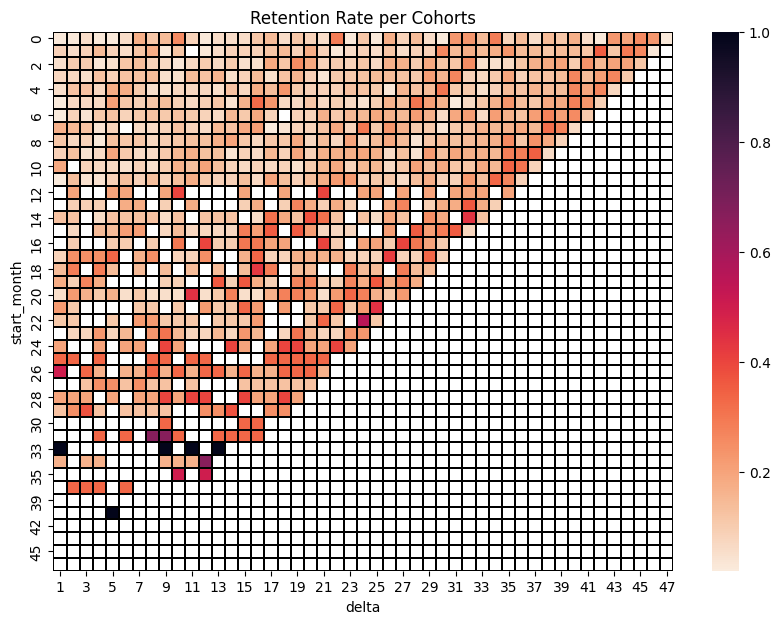

In [147]:
#  Нарисуем тепловую карту
plt.figure(figsize=(10, 7))
plt.title('Retention Rate per Cohorts')
sns.heatmap(retention_pivot.iloc[:, 1:], cmap="rocket_r",
            fmt='.2%', linewidths=0.1, linecolor='black')

### Что мы видим:  
1. Видим, что для новых пользвателей (пришедших за последние полгода) retention'а практически нет!
2. Среди пользователей, совершивших первую покупку подгода-год назад, retention сильно неоднородный: в какие-то месяца близок к 100%, но чаще нулевой
3. Менее неоднородный retention наблюдается также среди пользователей, совершивших первую покупку два года-год назад: они немного более стабильны в своей возвращаемости, при этом есть как клеткие с нулевые retention'ом, так и с достаточно высоким
4. Самые стабильные пользватели - совершивние первую покупку в течение первого года с начала ведения БД. Возвращаемость есть каждый месяц, хоть, возможно, относительно невысокая
5. Отметим, что в данных наблюдается сезонность: примерно каждый 12 месяцев retention возрастает: особенно это заметно для "старичков", но и для пользователей, относящихся к средним когортам, такой тренд прослеживается  

Посмотрим ещё раз на новых пользователей и разберемся в причинах неоднородного retention'а  
Сколько вообще новых пользователей приходит в магазин ежемесячно? Вот:

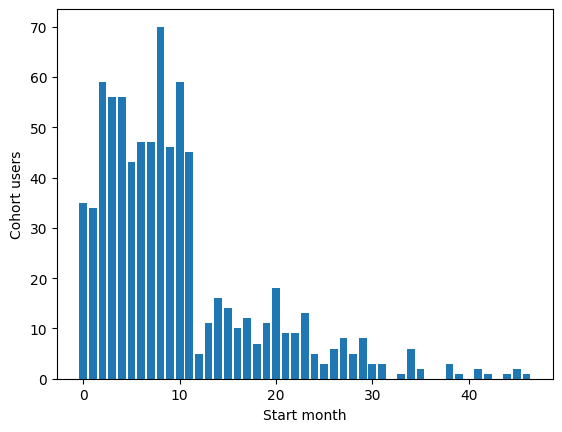

In [148]:
plt.figure()

x = initial_users_count['start_month']
y = initial_users_count['cohort_users']
plt.xlabel('Start month')
plt.ylabel('Cohort users')

plt.bar(x, y)
plt.show()

Видим, что через год после начала ведения БД приток новых пользователей резко упал и в целом продолжаем падать до сих пор. То есть проблема интернет-магазина в том, что:  
a) Приток новых пользователей крайне мал  
b) Мало приходит $\rightarrow$ мало возвращается, отсюда такой низкий retention у молодых когорт  
c) Неоднородность retention'a молодых когорт связана с малым числов пользователей в этих когортах  

Таким образом:  
1. Проблема, вероятнее всего, не в проблемах с доставкой, а с привлечением и удежанием новых пользователей  
2. Инструмент для самостоятельного принятия решений по качеству удержания ползьвательской базы - таблица с когортным анализом, которая наглядно показывает, насколько охотно покупатели возвращаются в магазин